In [21]:
import pandas as pd
import read_msalign


result = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/FDR/BA_ms2_toppic_prsm_single.tsv", delimiter="\t")

verifier = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")

# r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation2/B_SimulationResult.csv", delimiter="\t")

spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/FDR/BA_ms2.msalign")

spec_dict = {}
for spec in spec_list:
    spec_dict[str(spec.header.spec_scan)] = spec

for index, row in result.iterrows():
    result.loc[index, "Scan(other)"] = int(spec_dict[str(row["Scan(s)"])].header.title) % 100000



result["Scan_true"] = result["Scan(s)"] % 100000

result = result.sort_values(by=["Scan_true", "Scan(other)"])

verifiedResult = pd.merge(result,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications"]], left_on='Scan_true', right_on="Scan(s)", how='left', suffixes=("", "_TrueB"))

finalResult = pd.merge(verifiedResult,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications"]], left_on='Scan(other)', right_on="Scan(s)", how='left', suffixes=("", "_TrueA"))


finalResult["Verified_ProteinA"] = (finalResult["Protein accession"] == finalResult["Protein accession_TrueA"])
finalResult["Verified_ProteoformA"] = (finalResult["Protein accession"] == finalResult["Protein accession_TrueA"]) & (abs(finalResult["Proteoform mass"] - finalResult["Proteoform mass_TrueA"]) < 1.5)

finalResult["Verified_ProteinB"] = (finalResult["Protein accession"] == finalResult["Protein accession_TrueB"])
finalResult["Verified_ProteoformB"] = (finalResult["Protein accession"] == finalResult["Protein accession_TrueB"]) & (abs(finalResult["Proteoform mass"] - finalResult["Proteoform mass_TrueB"]) < 1.5)

print(len(finalResult[finalResult["Verified_ProteinA"] == True]) / len(finalResult))

print(len(finalResult[finalResult["Verified_ProteinB"] == True]) / len(finalResult))

print(len(finalResult[finalResult["Verified_ProteoformA"] == True]) / len(finalResult))

print(len(finalResult[finalResult["Verified_ProteoformB"] == True]) / len(finalResult))

finalResult.drop(columns=["Scan_true"], inplace=True)

# finalResultr2 = pd.merge(finalResult, r1[["Scan(s)", "Verified_ProteinA", "Verified_ProteinB"]], on="Scan(s)", how="left", suffixes=("", "_r1"))

finalResult.to_csv("SimulationResult.csv", sep="\t")

0.9912280701754386
0.005398110661268556
0.9757085020242915
0.0


In [23]:
a_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/A_ms2.msalign")
b_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/B_ms2.msalign")
ab_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/FDR/AB_ms2.msalign")
ba_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/FDR/BA_ms2.msalign")

A = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/A_SimulationResult.csv", delimiter="\t")
B = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/B_SimulationResult.csv", delimiter="\t")
AB = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/FDR/AB_SimulationResult.csv", delimiter="\t")
BA = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/FDR/BA_SimulationResult.csv", delimiter="\t")

    
pairs = []
for spec in a_spec_list:
    pairs.append(frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)))

accessA = {}
for pair in pairs:
    for spec in a_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessA[pair] = spec.header.spec_scan

accessB = {}
for pair in pairs:
    for spec in b_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessB[pair] = spec.header.spec_scan

accessAB = {}
for pair in pairs:
    for spec in ab_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessAB[pair] = spec.header.spec_scan

accessBA = {}
for pair in pairs:
    for spec in ba_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessBA[pair] = spec.header.spec_scan

output_dict = {"Pair": [], 
                "A+B_1": [], 
                "A+B_1 peaks": [], 
                "A+B_1 E-value": [], 
                "A+B_2": [], 
                "A+B_2 peaks": [], 
                "A+B_2 E-value": [], 
                "B+A_1": [], 
                "B+A_1 peaks": [],
                "B+A_1 E-value": [], 
                "B+A_2": [], 
                "B+A_2 peaks": [], 
                "B+A_2 E-value": []}
    
def checkCondition(prsm):
    if prsm.empty:
        return "-"
    elif prsm.iloc[0].at["Verified_ProteinA"]:
        return "A"
    elif prsm.iloc[0].at["Verified_ProteinB"]:
        return "B"
    else:
        return "C"
        
def getValue(prsm, key):
    if prsm.empty:
        if key == "#matched peaks":
            return 0
        else:
            return 1
    return prsm.iloc[0].at[key]
    

for pair in pairs:
    # pair = eval(pair)
    output_dict["Pair"].append(pair)
    prsm_A = A.loc[A["Scan(s)"] == accessA[pair]]
    output_dict["A+B_1"].append(checkCondition(prsm_A))
    output_dict["A+B_1 peaks"].append(getValue(prsm_A, "#matched peaks"))
    output_dict["A+B_1 E-value"].append(getValue(prsm_A, "E-value"))
    prsm_AB = AB.loc[AB["Scan(s)"] == accessAB[pair]]
    output_dict["A+B_2"].append(checkCondition(prsm_AB))
    output_dict["A+B_2 peaks"].append(getValue(prsm_AB, "#matched peaks"))
    output_dict["A+B_2 E-value"].append(getValue(prsm_AB, "E-value"))
    prsm_B = B.loc[B["Scan(s)"] == accessB[pair]]
    output_dict["B+A_1"].append(checkCondition(prsm_B))
    output_dict["B+A_1 peaks"].append(getValue(prsm_B, "#matched peaks"))
    output_dict["B+A_1 E-value"].append(getValue(prsm_B, "E-value"))
    prsm_BA = BA.loc[BA["Scan(s)"] == accessBA[pair]]
    output_dict["B+A_2"].append(checkCondition(prsm_BA))
    output_dict["B+A_2 peaks"].append(getValue(prsm_BA, "#matched peaks"))
    output_dict["B+A_2 E-value"].append(getValue(prsm_BA, "E-value"))

outputdf = pd.DataFrame(output_dict)

outputdf.to_csv("Result.tsv", sep="\t")

In [10]:
import pandas as pd
import read_msalign

a_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/ABBA100_ms2.msalign")

pairs = []
for spec in a_spec_list:
    pairs.append(frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)))

accessA = {}
for pair in pairs:
    for spec in a_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessA[pair] = spec.header.spec_scan

a_spec_dict = {}
for spec in a_spec_list:
    a_spec_dict[str(spec.header.spec_scan)] = spec

for pair in pairs:
    spec = a_spec_dict[str(accessA[pair])]
    title = int(spec.header.title) % 100000
    spec.header.title = str(spec.header.spec_scan % 100000)
    spec.header.spec_scan = title
    spec.header.spec_id = title
    pre_mz_list = spec.header.pre_mz_list
    pre_charge_list = spec.header.pre_charge_list
    pre_mass_list = spec.header.pre_mass_list
    pre_inte_list = spec.header.pre_inte_list
    pre_id_list = spec.header.pre_id_list

    pre_mz_list[0], pre_mz_list[1] = pre_mz_list[1], pre_mz_list[0]
    pre_charge_list[0], pre_charge_list[1] = pre_charge_list[1], pre_charge_list[0]
    pre_mass_list[0], pre_mass_list[1] = pre_mass_list[1], pre_mass_list[0]
    pre_inte_list[0], pre_inte_list[1] = pre_inte_list[1], pre_inte_list[0]
    pre_id_list[0], pre_id_list[1] = pre_id_list[1], pre_id_list[0]

    spec.header.pre_mz_list = pre_mz_list
    spec.header.pre_charge_list = pre_charge_list
    spec.header.pre_mass_list = pre_mass_list
    spec.header.pre_inte_list = pre_inte_list
    spec.header.pre_id_list = pre_id_list

output_spec_list = read_msalign.sortScans(a_spec_list)

read_msalign.write_spec_file("fixed_ms2.msalign", output_spec_list)


In [29]:
import pandas as pd
import read_msalign

a_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/A_ms2.msalign")

result = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/Result.tsv", delimiter="\t")

pairs = []
for spec in a_spec_list:
    pairs.append(frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)))

accessA = {}
for pair in pairs:
    for spec in a_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessA[pair] = spec.header.spec_scan

fulltable = result.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])

import json
import random

random.seed(0)

fulllist = fulltable.get_group(("A", "B", "B", "A"))["Pair"].to_list()

dir = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_html/toppic_prsm_cutoff/data_js/prsms/prsm"

reference = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")

a_spec_dict = {}
for spec in a_spec_list:
    a_spec_dict[int(spec.header.spec_scan)] = spec

percentage = 1.0

outputList = []

for pair in fulllist:
    spec = a_spec_dict[accessA[eval(pair)]]
    curr_peak_list = spec.peak_list
    currecscore = 1
    for idx in range(0, len(curr_peak_list)):
        if currecscore >= curr_peak_list[idx].ecscore:
            currecscore = curr_peak_list[idx].ecscore
        else:
            break
    a_peaks = curr_peak_list[0:idx]
    b_peaks = curr_peak_list[idx:]
    if (len(a_spec_list) == len(curr_peak_list)):
        print("wtf something is wrong and scan is " + spec.header.spec_scan)

    prsmID = reference[reference["Scan(s)"] == int(spec.header.title)].iloc[0]["Prsm ID"]
    b_matched = []
    b_non_matched = []
    with open(dir + str(prsmID) + ".js") as file:
        file.readline()
        toppic = json.loads(file.read())
        b_peak_list = toppic["prsm"]["ms"]["peaks"]["peak"]
        for idx in range(0, len(b_peak_list)):
            if "matched_ions" in b_peak_list[idx]:
                b_matched.append(idx)
            else:
                b_non_matched.append(idx)

    b_random_idx = sorted(random.sample(b_matched, int(len(b_matched) * (1 - percentage))) + random.sample(b_non_matched, int(len(b_non_matched) * (1 - percentage))))

    for idx in b_random_idx:
        a_peaks.append(b_peaks[idx])

    spec.peak_list = a_peaks

    outputList.append(spec)

read_msalign.write_spec_file("ABBA" + str(int(percentage*100)) + "_ms2.msalign", a_spec_list)

1906
128


<Axes: >

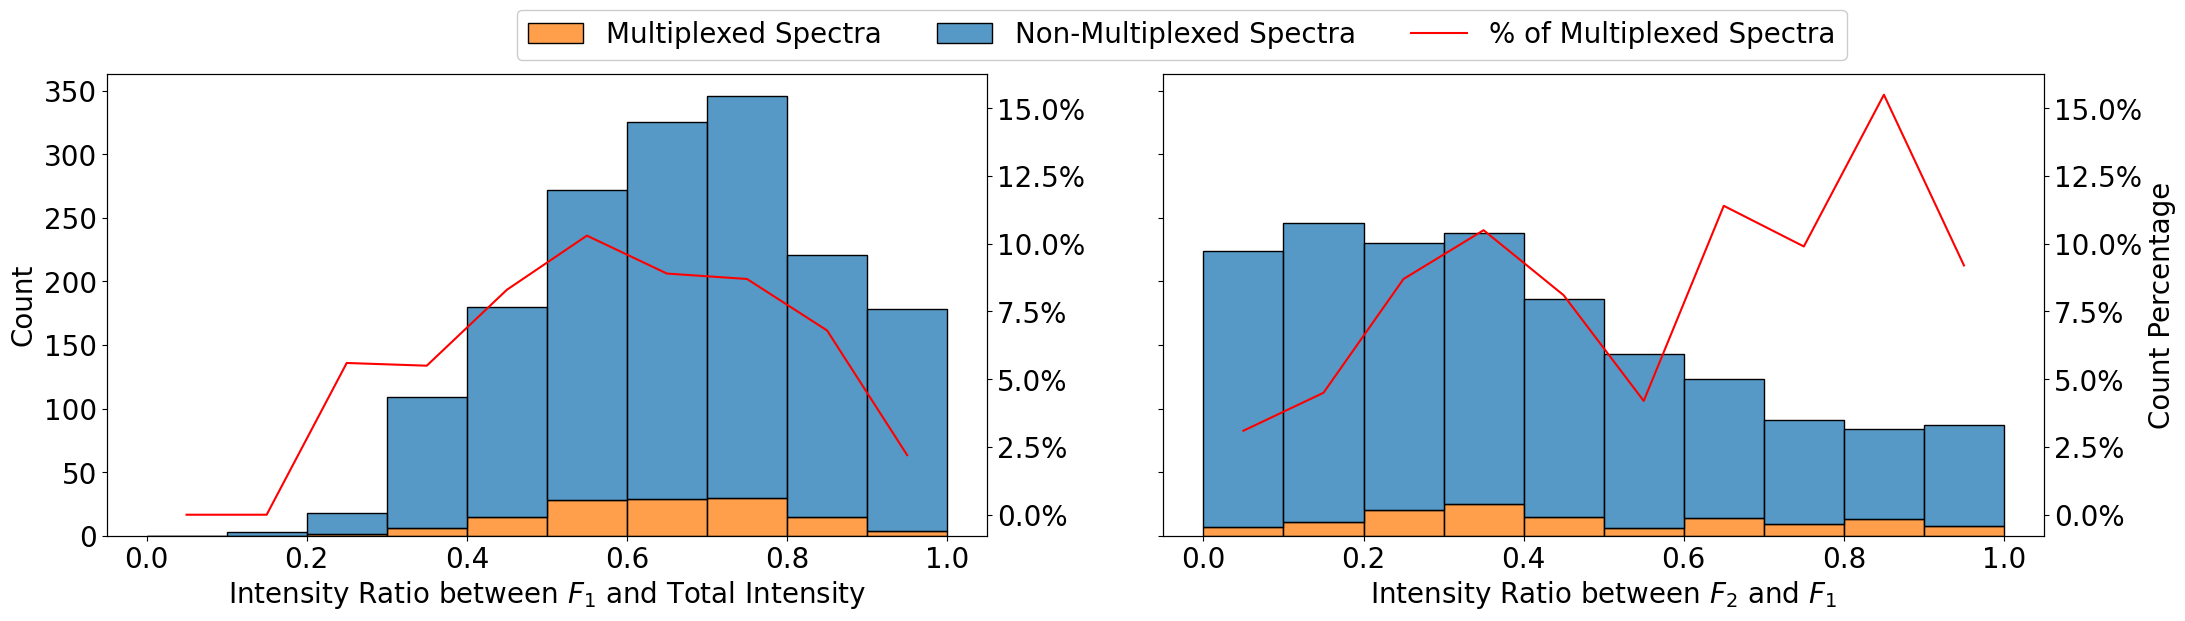

In [18]:
import read_msalign
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt


spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2.msalign")

r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Multiplex/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")

temp = r1.merge(r2, how="outer", on=["Scan(s)"])
print(temp.shape[0])
merge = r1.merge(r2, how="inner", on=["Scan(s)"])
print(merge.shape[0])

fig, (ax0, ax2) = plt.subplots(1, 2, figsize=(25, 6), sharex=True, sharey=True)

r1scanlist = r1["Scan(s)"].tolist()
r2scanlist = r2["Scan(s)"].tolist()
mergescanlist = merge["Scan(s)"].tolist()
#or len(spec.header.pre_inte_list) == 1 or float(spec.header.pre_inte_list[1]) == float(0)
intensity_percent = []
merged_percent = []
for spec in spec_list:
    if spec.header.pre_inte_list[0] == '' or float(spec.header.pre_inte_list[0]) == float(0) or len(spec.header.pre_inte_list) == 1 or float(spec.header.pre_inte_list[1]) == float(0):
        continue
    if not ((spec.header.spec_scan in r1scanlist or spec.header.spec_scan in r2scanlist)):
        continue
    total = sum(map(float, spec.header.pre_inte_list))
    if spec.header.spec_scan in mergescanlist:
        merged_percent.append(float(spec.header.pre_inte_list[1]) / float(spec.header.pre_inte_list[0]))
    else:
        intensity_percent.append(float(spec.header.pre_inte_list[1]) / float(spec.header.pre_inte_list[0]) )

df = pd.DataFrame(columns=["Intensity Ratio between $F_2$ and $F_1$", "Type of Spectra"])
for num in intensity_percent:
    df.loc[len(df)] = [num, "Spectra with at least 2 Features"]

for num in merged_percent:
    df.loc[len(df)] = [num, "Multiplexed Spectra"]

plt.rcParams.update({'font.size': 20})

ax1 = ax0.twinx()
ax3 = ax2.twinx()

# share the secondary axes
ax1.sharey(ax3)
sns.histplot(data=df, x="Intensity Ratio between $F_2$ and $F_1$", hue="Type of Spectra", multiple="stack", stat="count", binwidth=0.1, binrange=(0, 1), label="435", legend=False, ax=ax2)

labels = [int(v) if v else 0 for v in ax2.containers[0].datavalues]
labelsnon = [int(v) if v else 0 for v in ax2.containers[1].datavalues]
total = [sum(x) for x in zip(labels, labelsnon)]
result = [round((x / y) * 100, 1) if not y == 0 else 0 for x,y in zip(labels, total)]

sns.lineplot(x=[x / 100.0 + 0.05 for x in range(0, 100, 10)], y=result, ax=ax3, color="red", label="% of Multiplexed Spectra", legend=False)

ax3.yaxis.set_major_formatter(mtick.PercentFormatter())

ax3.set_ylabel("Count Percentage")


handles1, labels1 = ax2.get_legend_handles_labels()
handles2, labels2 = ax3.get_legend_handles_labels()
labels1 = ["Multiplexed Spectra", "Non-Multiplexed Spectra"]
ax2.legend(handles1+handles2, 
           [text for text in labels1+labels2], 
           loc='lower left', fancybox=True, framealpha=1, bbox_to_anchor=(-0.75, 1), ncol = 3)


intensity_percent = []
merged_percent = []
for spec in spec_list:
    if spec.header.pre_inte_list[0] == '' or float(spec.header.pre_inte_list[0]) == float(0) or len(spec.header.pre_inte_list) == 1 or float(spec.header.pre_inte_list[1]) == float(0):
        continue
    if not ((spec.header.spec_scan in r1scanlist or spec.header.spec_scan in r2scanlist)):
        continue
    total = sum(map(float, spec.header.pre_inte_list))
    if spec.header.spec_scan in mergescanlist:
        merged_percent.append(float(spec.header.pre_inte_list[0]) / total)
    else:
        intensity_percent.append(float(spec.header.pre_inte_list[0]) / total )

df = pd.DataFrame(columns=["Intensity Ratio between $F_1$ and Total Intensity", "Type of Spectra"])
for num in intensity_percent:
    df.loc[len(df)] = [num, "Spectra with at least 2 Features"]

for num in merged_percent:
    df.loc[len(df)] = [num, "Multiplexed Spectra"]

sns.histplot(data=df, x="Intensity Ratio between $F_1$ and Total Intensity", hue="Type of Spectra", multiple="stack", stat="count", binwidth=0.1, binrange=(0, 1), label="435", legend=False, ax=ax0)

labels = [int(v) if v else 0 for v in ax0.containers[0].datavalues]
labelsnon = [int(v) if v else 0 for v in ax0.containers[1].datavalues]
total = [sum(x) for x in zip(labels, labelsnon)]
result = [round((x / y) * 100, 1) if not y == 0 else 0 for x,y in zip(labels, total)]

sns.lineplot(x=[x / 100.0 + 0.05 for x in range(0, 100, 10)], y=result, ax=ax1, color="red", label="% of Multiplexed", legend=False)

In [24]:
import pandas as pd

df = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/FDR/Result.tsv", delimiter="\t")

df.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"]).count()

Unnamed: 0  Pair  A+B_1 peaks  A+B_1 E-value  \
A+B_1 A+B_2 B+A_1 B+A_2                                                 
-     -     -     A               6     6            6              6   
      A     -     A               5     5            5              5   
      B     -     -               5     5            5              5   
                  A              14    14           14             14   
                  B               2     2            2              2   
            B     -              19    19           19             19   
                  A             122   122          122            122   
                  C               3     3            3              3   
      C     -     A               1     1            1              1   
A     -     -     A              19    19           19             19   
            A     A               1     1            1              1   
            B     A               1     1            1              1   
      B     -     A             143   143          143            143   
            A     -              20    20           20             20   
                  A             105   105          105            105   
                  B               6     6            6              6   
                  C               2     2            2              2   
            B     -               1     1            1              1   
                  A             936   936          936            936   
      C     -     A               7     7            7              7   
B     A     B     A               2     2            2              2   
      B     B     -               8     8            8              8   
                  A             104   104          104            104   
      C     B     A               3     3            3              3   

                         A+B_2 peaks  A+B_2 E-value  B+A_1 peaks  \
A+B_1 A+B_2 B+A_1 B+A_2                                            
-     -     -     A                6              6            6   
      A     -     A                5              5            5   
      B     -     -                5              5            5   
                  A               14             14           14   
                  B                2              2            2   
            B     -               19             19           19   
                  A              122            122          122   
                  C                3              3            3   
      C     -     A                1              1            1   
A     -     -     A               19             19           19   
            A     A                1              1            1   
            B     A                1              1            1   
      B     -     A              143            143          143   
            A     -               20             20           20   
                  A              105            105          105   
                  B                6              6            6   
                  C                2              2            2   
            B     -                1              1            1   
                  A              936            936          936   
      C     -     A                7              7            7   
B     A     B     A                2              2            2   
      B     B     -                8              8            8   
                  A              104            104          104   
      C     B     A                3              3            3   

                         B+A_1 E-value  B+A_2 peaks  B+A_2 E-value  
A+B_1 A+B_2 B+A_1 B+A_2                                             
-     -     -     A                  6            6              6  
      A     -     A                  5            5              5  
      B     -     -                  5            5              5  
            

In [119]:
import pandas as pd
import csv
import copy

df = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/Result_1Peaks.tsv", delimiter="\t")

with open("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/Result_1Peaks.tsv") as f:
    prsmspeaks = [{k: v for k, v in row.items()}
        for row in csv.DictReader(f, skipinitialspace=True, delimiter="\t")]
    
prsmsvalue = copy.deepcopy(prsmspeaks)

prsmcombined = copy.deepcopy(prsmspeaks)

In [109]:
#P1 and P2
query = df[(df["A+B_1"] == "B") & (df["A+B_2"] == "B") & (df["B+A_1"] == "B") & (df["B+A_2"] == "A")]

query["#matched peaks"] = query["A+B_1 peaks"] >= query["A+B_2 peaks"]

query["E-value"] = query["A+B_1 E-value"] <= query["A+B_2 E-value"]

query["Difference"] = ~(query["#matched peaks"] == query["E-value"])

print(query[query["#matched peaks"]].shape[0], query[~query["#matched peaks"]].shape[0])

print(query[query["E-value"]].shape[0], query[~query["E-value"]].shape[0])

print(query[query["Difference"]].shape[0])

21 60
17 64
12


/tmp/ipykernel_33159/3165887939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["#matched peaks"] = query["A+B_1 peaks"] >= query["A+B_2 peaks"]
/tmp/ipykernel_33159/3165887939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["E-value"] = query["A+B_1 E-value"] <= query["A+B_2 E-value"]
/tmp/ipykernel_33159/3165887939.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [110]:
for idx in query[query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["A+B_2"] = "-"
    prsmspeaks[idx]["A+B_2 peaks"] = 0
    prsmspeaks[idx]["A+B_2 E-value"] = 1

for idx in query[~query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["A+B_1"] = "-"
    prsmspeaks[idx]["A+B_1 peaks"] = 0
    prsmspeaks[idx]["A+B_1 E-value"] = 1

for idx in query[query["E-value"]].index.tolist():
    prsmsvalue[idx]["A+B_2"] = "-"
    prsmsvalue[idx]["A+B_2 peaks"] = 0
    prsmsvalue[idx]["A+B_2 E-value"] = 1

for idx in query[~query["E-value"]].index.tolist():
    prsmsvalue[idx]["A+B_1"] = "-"
    prsmsvalue[idx]["A+B_1 peaks"] = 0
    prsmsvalue[idx]["A+B_1 E-value"] = 1

In [105]:
#P3 and P4
query = df[(df["A+B_1"] == "A") & (df["A+B_2"] == "B") & (df["B+A_1"] == "A") & (df["B+A_2"] == "A")]

query["#matched peaks"] = query["B+A_1 peaks"] >= query["B+A_2 peaks"]

query["E-value"] = query["B+A_1 E-value"] <= query["B+A_2 E-value"]

query["Difference"] = ~(query["#matched peaks"] == query["E-value"])

print(query[query["#matched peaks"]].shape[0], query[~query["#matched peaks"]].shape[0])

print(query[query["E-value"]].shape[0], query[~query["E-value"]].shape[0])

print(query[query["Difference"]].shape[0])

26 58
22 62
10


/tmp/ipykernel_33159/2239245553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["#matched peaks"] = query["B+A_1 peaks"] >= query["B+A_2 peaks"]
/tmp/ipykernel_33159/2239245553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["E-value"] = query["B+A_1 E-value"] <= query["B+A_2 E-value"]
/tmp/ipykernel_33159/2239245553.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [106]:
for idx in query[query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["B+A_2"] = "-"
    prsmspeaks[idx]["B+A_2 peaks"] = 0
    prsmspeaks[idx]["B+A_2 E-value"] = 1

for idx in query[~query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["B+A_1"] = "-"
    prsmspeaks[idx]["B+A_1 peaks"] = 0
    prsmspeaks[idx]["B+A_1 E-value"] = 1

for idx in query[query["E-value"]].index.tolist():
    prsmsvalue[idx]["B+A_2"] = "-"
    prsmsvalue[idx]["B+A_2 peaks"] = 0
    prsmsvalue[idx]["B+A_2 E-value"] = 1

for idx in query[~query["E-value"]].index.tolist():
    prsmsvalue[idx]["B+A_1"] = "-"
    prsmsvalue[idx]["B+A_1 peaks"] = 0
    prsmsvalue[idx]["B+A_1 E-value"] = 1

In [126]:
#P1 and P4
query = df[(df["A+B_1"] == "B") & (df["A+B_2"] == "-") & (df["B+A_1"] == "B") & (df["B+A_2"] == "A")]

query["#matched peaks"] = query["A+B_1 peaks"] >= query["B+A_2 peaks"]

query["E-value"] = query["A+B_1 E-value"] <= query["B+A_2 E-value"]

query["Combined"] = (query["A+B_1 peaks"] + query["A+B_2 peaks"]) >= (query["B+A_1 peaks"] + query["B+A_2 peaks"])

print(query[query["#matched peaks"]].shape[0], query[~query["#matched peaks"]].shape[0])

print(query[query["E-value"]].shape[0], query[~query["E-value"]].shape[0])

print(query[query["Combined"]].shape[0], query[~query["Combined"]].shape[0])

40 0
35 5
0 40


/tmp/ipykernel_33159/1887306537.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["#matched peaks"] = query["A+B_1 peaks"] >= query["B+A_2 peaks"]
/tmp/ipykernel_33159/1887306537.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["E-value"] = query["A+B_1 E-value"] <= query["B+A_2 E-value"]
/tmp/ipykernel_33159/1887306537.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [127]:
for idx in query[query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["B+A_2"] = "-"
    prsmspeaks[idx]["B+A_2 peaks"] = 0
    prsmspeaks[idx]["B+A_2 E-value"] = 1

for idx in query[~query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["A+B_1"] = "-"
    prsmspeaks[idx]["A+B_1 peaks"] = 0
    prsmspeaks[idx]["A+B_1 E-value"] = 1

for idx in query[query["E-value"]].index.tolist():
    prsmsvalue[idx]["B+A_2"] = "-"
    prsmsvalue[idx]["B+A_2 peaks"] = 0
    prsmsvalue[idx]["B+A_2 E-value"] = 1

for idx in query[~query["E-value"]].index.tolist():
    prsmsvalue[idx]["A+B_1"] = "-"
    prsmsvalue[idx]["A+B_1 peaks"] = 0
    prsmsvalue[idx]["A+B_1 E-value"] = 1

In [134]:
#P2 and P3
query = df[(df["A+B_1"] == "A") & (df["A+B_2"] == "B") & (df["B+A_1"] == "A") & (df["B+A_2"] == "-")]

query["#matched peaks"] = query["A+B_2 peaks"] >= query["B+A_1 peaks"]

query["E-value"] = query["A+B_2 E-value"] <= query["B+A_1 E-value"]

query["Combined"] = (query["A+B_1 peaks"] + query["A+B_2 peaks"]) >= (query["B+A_1 peaks"] + query["B+A_2 peaks"])

print(query[query["#matched peaks"]].shape[0], query[~query["#matched peaks"]].shape[0])

print(query[query["E-value"]].shape[0], query[~query["E-value"]].shape[0])

print(query[query["Combined"]].shape[0], query[~query["Combined"]].shape[0])

1 58
9 50
59 0


/tmp/ipykernel_33159/827121865.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["#matched peaks"] = query["A+B_2 peaks"] >= query["B+A_1 peaks"]
/tmp/ipykernel_33159/827121865.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["E-value"] = query["A+B_2 E-value"] <= query["B+A_1 E-value"]
/tmp/ipykernel_33159/827121865.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [135]:
for idx in query[query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["B+A_1"] = "-"
    prsmspeaks[idx]["B+A_1 peaks"] = 0
    prsmspeaks[idx]["B+A_1 E-value"] = 1

for idx in query[~query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["A+B_2"] = "-"
    prsmspeaks[idx]["A+B_2 peaks"] = 0
    prsmspeaks[idx]["A+B_2 E-value"] = 1

for idx in query[query["E-value"]].index.tolist():
    prsmsvalue[idx]["B+A_1"] = "-"
    prsmsvalue[idx]["B+A_1 peaks"] = 0
    prsmsvalue[idx]["B+A_1 E-value"] = 1

for idx in query[~query["E-value"]].index.tolist():
    prsmsvalue[idx]["A+B_2"] = "-"
    prsmsvalue[idx]["A+B_2 peaks"] = 0
    prsmsvalue[idx]["A+B_2 E-value"] = 1

In [136]:
outputdf_peaks = pd.DataFrame(prsmspeaks)
outputdf_values = pd.DataFrame(prsmsvalue)
outputdf_combined = pd.DataFrame(prsmcombined)

outputdf_peaks.to_csv("Result_1Peaks_2Peaks.tsv", sep="\t")
outputdf_values.to_csv("Result_1Peaks_2Value.tsv", sep="\t")
outputdf_combined.to_csv("Result_1Peaks_2Combined.tsv", sep="\t")

In [129]:
import pandas as pd
import read_msalign

intputfileA = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/ABBA_ms2_toppic_prsm_single.tsv"
intputfileAB = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/AB_ms2_toppic_prsm_single.tsv"
intputfileB = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/B_ms2_toppic_prsm.tsv"
intputfileBA = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/BA_ms2_toppic_prsm.tsv"


a_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/A_ms2.msalign")

b_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/B_ms2.msalign")

result = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/Result.tsv", delimiter="\t")

pairs = []
for spec in a_spec_list:
    pairs.append(frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)))

accessA = {}
for pair in pairs:
    for spec in a_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessA[pair] = spec.header.spec_scan

accessB = {}
for pair in pairs:
    for spec in b_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessB[pair] = spec.header.spec_scan

fulltable = result.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])

fulllist = fulltable.get_group(("A", "B", "B", "A"))["Pair"].to_list()

a_scans = []
for pair in fulllist:
    a_scans.append(accessA[eval(pair)])

b_scans = []
for pair in fulllist:
    b_scans.append(accessB[eval(pair)])


file = pd.read_csv(intputfileA, delimiter="\t")

outputfile = file[file["Scan(s)"].isin(a_scans)]
outputfile.to_csv(intputfileA, sep="\t")

file = pd.read_csv(intputfileAB, delimiter="\t")

outputfile = file[file["Scan(s)"].isin(a_scans)]
outputfile.to_csv(intputfileAB, sep="\t")

file = pd.read_csv(intputfileB, delimiter="\t")

outputfile = file[file["Scan(s)"].isin(b_scans)]
outputfile.to_csv(intputfileB, sep="\t")

file = pd.read_csv(intputfileBA, delimiter="\t")

outputfile = file[file["Scan(s)"].isin(b_scans)]
outputfile.to_csv(intputfileBA, sep="\t")

<Figure size 1000x600 with 0 Axes>

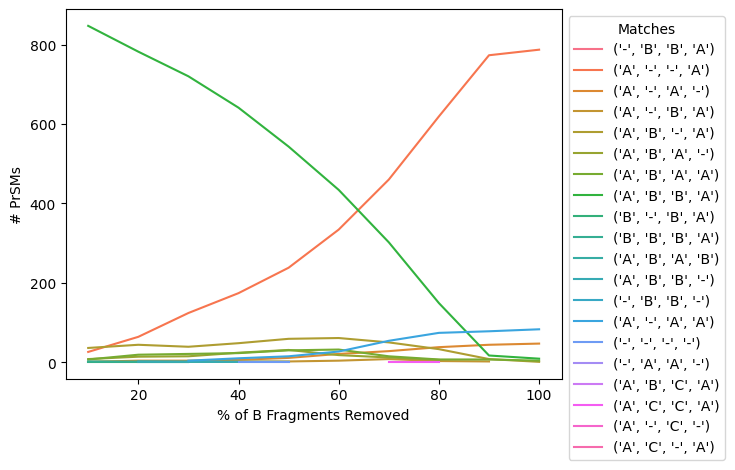

<Figure size 1000x600 with 0 Axes>

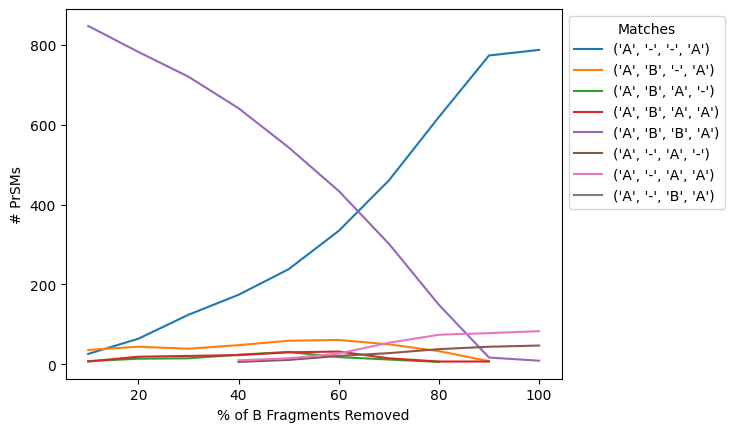

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates


r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/10%/Result.tsv", delimiter="\t")
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/20%/Result.tsv", delimiter="\t")
r3 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/30%/Result.tsv", delimiter="\t")
r4 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/40%/Result.tsv", delimiter="\t")
r5 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/50%/Result.tsv", delimiter="\t")
r6 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/60%/Result.tsv", delimiter="\t")
r7 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/70%/Result.tsv", delimiter="\t")
r8 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/80%/Result.tsv", delimiter="\t")
r9 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/90%/Result.tsv", delimiter="\t")
r10 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/Result.tsv", delimiter="\t")

df = pd.DataFrame(columns=["Matches", "% of B Fragments Removed", "# PrSMs"])

r1 = r1.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r1.groups.keys():
    df.loc[len(df)] = [key,10,len(r1.get_group(key))]

r2 = r2.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r2.groups.keys():
    df.loc[len(df)] = [key,20,len(r2.get_group(key))]

r3 = r3.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r3.groups.keys():
    df.loc[len(df)] = [key,30,len(r3.get_group(key))]

r4 = r4.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r4.groups.keys():
    df.loc[len(df)] = [key,40,len(r4.get_group(key))]

r5 = r5.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r5.groups.keys():
    df.loc[len(df)] = [key,50,len(r5.get_group(key))]

r6 = r6.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r6.groups.keys():
    df.loc[len(df)] = [key,60,len(r6.get_group(key))]

r7 = r7.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r7.groups.keys():
    df.loc[len(df)] = [key,70,len(r7.get_group(key))]

r8 = r8.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r8.groups.keys():
    df.loc[len(df)] = [key,80,len(r8.get_group(key))]

r9 = r9.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r9.groups.keys():
    df.loc[len(df)] = [key,90,len(r9.get_group(key))]

r10 = r10.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r10.groups.keys():
    df.loc[len(df)] = [key,100,len(r10.get_group(key))]

new_df = df[df['# PrSMs'] >= 5]


plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.lineplot(data=df, x="% of B Fragments Removed", y="# PrSMs", hue="Matches")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="% of B Fragments Removed", y="# PrSMs", hue="Matches")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))